In [12]:
import numpy as np
import NNAccelerator
import time
import heapq
from PIL import Image
from IPython.display import display

In [13]:
def load_image(infilename):
    img = Image.open(infilename)
    img.load()
    img = img.convert('RGB')
    data = np.asarray(img,dtype=np.uint8)
    return  data

In [14]:
VGG16Version = 'VGG_16'
cnnName = 'VGG16'

bitFileName = 'cnna7.16.8.3.800' # 16 bit with 8 PEs and output BW of 3 after the CLB 
bitFile = 'bitFiles/172MHZ/16_128_8_3_32.bit' # Parameters [16,128,16,3,32] CNNA16

#bitFileName = 'cnna7.8.16.1.798' # 8 bit with 16 PEs and output BW of 1 after the CLB
#bitFile = 'bitFiles/172MHZ/8_128_16_1_42.bit' # Parameters [8,128,16,1,42] CNNA8_1

#bitFileName = 'cnna7.8.8.3.546' # 8 bit with 8 PEs and output BW of 3 after the CLB
#bitFile = 'bitFiles/172MHZ/8_128_8_3_42.bit' # Parameters [8,128,8,3,42] CNNA8_2
    
dataset = '_detect'

cnnSpec = 'cnnSpecs/' + cnnName + '/' + cnnName+ dataset + '.json' # JSON specification of CNN model
cnnWeights = 'cnnSpecs/' + cnnName + '/' + cnnName + dataset + '_pre_'+ bitFileName+ '.h5' # Preprocessed weights
beforeAccLoad = time.time()
acc = NNAccelerator.NNAccelerator(bitfile = bitFile, NNJsonSpec = cnnSpec, H5Weights = cnnWeights, preConverted = True, preAlligned = True,verboseLevel = 4,dmaSafe = True)
afterAccLoad = time.time()
print('Loading time: ',afterAccLoad-beforeAccLoad)
acc.verboseLevel = 4

dataW:  16 , dataP:  2 , dmaBW:  8 , PE_N:  8 , peBwN:  8 , dataOut:  3 , wbufSize:  800
DMA MULT:  4
input_1 , kernelSize:  0 , nFilters:  0, filtersPrSplit:  0 , nSplits:  1 , outputSize:  [224, 224, 3]
, paddingSize:  1.0block1_conv1 , kernelSize:  [3, 3] , nFilters:  64, filtersPrSplit:  64 , nSplits:  1.0 , outputSize:  (224.0, 224.0, 64)
, paddingSize:  1.0block1_conv2 , kernelSize:  [3, 3] , nFilters:  64, filtersPrSplit:  64 , nSplits:  1.0 , outputSize:  (224.0, 224.0, 64)
, paddingSize:  0block1_pool , kernelSize:  [2, 2] , nFilters:  0, filtersPrSplit:  0 , nSplits:  1 , outputSize:  (112.0, 112.0, 64)
, paddingSize:  1.0block2_conv1 , kernelSize:  [3, 3] , nFilters:  128, filtersPrSplit:  128 , nSplits:  1.0 , outputSize:  (112.0, 112.0, 128)
, paddingSize:  1.0block2_conv2 , kernelSize:  [3, 3] , nFilters:  128, filtersPrSplit:  128.0 , nSplits:  1.0 , outputSize:  (112.0, 112.0, 128)
, paddingSize:  0block2_pool , kernelSize:  [2, 2] , nFilters:  0, filtersPrSplit:  0 , n

loading weights for  dense_1, time taken:  3.3325905799865723
loading weights for  dense_2, time taken:  1.8763539791107178
loading weights for  dense_3, time taken:  0.007452726364135742
loading weights for  flatten_1, time taken:  0.0005433559417724609
loading weights for  input_1, time taken:  0.0004730224609375
parameters
depth:  64 , rowSize:  224.0 , stride:  2 , window:  2 , zeroPad: 0 , depthRaw:  8.0 , rowSizeY:  112.0 , imageSize:  401408.0
depth:  128 , rowSize:  112.0 , stride:  2 , window:  2 , zeroPad: 0 , depthRaw:  16.0 , rowSizeY:  56.0 , imageSize:  200704.0
depth:  256 , rowSize:  56.0 , stride:  2 , window:  2 , zeroPad: 0 , depthRaw:  32.0 , rowSizeY:  28.0 , imageSize:  100352.0
depth:  512 , rowSize:  28.0 , stride:  2 , window:  2 , zeroPad: 0 , depthRaw:  64.0 , rowSizeY:  14.0 , imageSize:  50176.0
depth:  512 , rowSize:  14.0 , stride:  2 , window:  2 , zeroPad: 0 , depthRaw:  64.0 , rowSizeY:  7.0 , imageSize:  12544.0
splits:  512.0  splits:  512.0  splits:

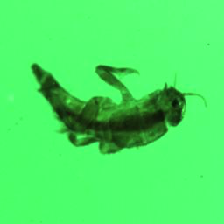

In [15]:
imageFile = 'detect/detect1_3.jpg'
img = load_image(imageFile)
convertedX = np.expand_dims(img,axis=0)
display(Image.fromarray(img))

In [16]:
acc.verboseLevel = 2
t = acc.predict(convertedX)

layer = 'dense_3'
outputs2 = acc.variableExtract(acc.outputs[layer][acc.layers[layer].finalOutIdx],5)
classes = heapq.nlargest(5,range(len(outputs2)),outputs2.__getitem__)
print('Result')
for i in range(5):
    print('    ', classes[i]+1 , outputs2[classes[i]])

print(t, acc.softmax(outputs2), np.sum(acc.softmax(outputs2)))

starting prediction
predicting:  input_1 layer time:  1.6450881958007812e-05
nDMAreceived:  0nDMAsent:  0
predicting:  block1_conv1, splits:  1.0   layer time:  0.017545461654663086
nDMAreceived:  9408nDMAsent:  401408
predicting:  block1_conv2, splits:  1.0   layer time:  0.08426952362060547
nDMAreceived:  401408nDMAsent:  401408
predicting:  block1_pool layer time:  0.013677120208740234
nDMAreceived:  401408nDMAsent:  100352
predicting:  block2_conv1, splits:  1.0   layer time:  0.04271101951599121
nDMAreceived:  100352nDMAsent:  200704
predicting:  block2_conv2, splits:  1.0   layer time:  0.08133196830749512
nDMAreceived:  200704nDMAsent:  200704
predicting:  block2_pool layer time:  0.006806135177612305
nDMAreceived:  200704nDMAsent:  50176
predicting:  block3_conv1, splits:  2.0   layer time:  0.04390716552734375
nDMAreceived:  100352nDMAsent:  150528
predicting:  block3_conv2, splits:  4.0   layer time:  0.08512449264526367
nDMAreceived:  401408nDMAsent:  250880
predicting:  blo

In [17]:
acc.verboseLevel = 0.2
t = acc.predict(convertedX)

layer = 'dense_3'
outputs2 = acc.variableExtract(acc.outputs[layer][acc.layers[layer].finalOutIdx],5)
classes = heapq.nlargest(5,range(len(outputs2)),outputs2.__getitem__)
print('Result')
for i in range(5):
    print('    ', classes[i]+1 , outputs2[classes[i]])

print(t, acc.softmax(outputs2), np.sum(acc.softmax(outputs2)))

starting prediction
time taken:  1.9653403759002686
Result
     2 0.463379
     3 0.463379
     5 0.463379
     1 0.442322
     4 0.43811
(1.9653403759002686, 1) [ 0.19764256  0.20184848  0.20184848  0.19681196  0.20184848] 1.0


In [7]:
acc.verboseLevel = 0.2
predictedClasses = list()
for i in range(5):
    for j in range(3):
        imageFile = 'detect/detect' + str(i+1) + '_' + str(j+1) + '.jpg'
        img = load_image(imageFile)
        convertedX = np.expand_dims(img,axis=0)
        #acc.outputs[layer][acc.layers[layer].finalOutIdx].invalidate()
        acc.predict(convertedX)
        layer = 'dense_3'
        outputs2 = acc.variableExtract(acc.outputs[layer][acc.layers[layer].finalOutIdx],5)
        classes = heapq.nlargest(5, range(len(outputs2)),outputs2.__getitem__)
        predictedClasses.append((i,classes))
        #time.sleep(0.5)
        
correct = 0
wrong = 0
for predicted in range(len(predictedClasses)):
    if predictedClasses[predicted][0] == predictedClasses[predicted][1][0]:
        correct += 1
    else:
        wrong += 1

print('correctness = ', correct/len(predictedClasses))

starting prediction
time taken:  1.9459657669067383
starting prediction
time taken:  1.9708101749420166
starting prediction
time taken:  1.9412035942077637
starting prediction
time taken:  1.9742372035980225
starting prediction
time taken:  1.9479660987854004
starting prediction
time taken:  1.9728567600250244
starting prediction
time taken:  1.9413819313049316
starting prediction
time taken:  1.971923828125
starting prediction
time taken:  1.943164587020874
starting prediction
time taken:  1.9729058742523193
starting prediction
time taken:  1.9404776096343994
starting prediction
time taken:  1.9714367389678955
starting prediction
time taken:  3.3143043518066406
starting prediction
time taken:  1.9734058380126953
starting prediction
time taken:  1.942373514175415
correctness =  0.2


In [8]:
for predicted in range(len(predictedClasses)):
    print(predictedClasses[predicted])

(0, [1, 2, 4, 0, 3])
(0, [1, 2, 4, 0, 3])
(0, [1, 2, 4, 0, 3])
(1, [1, 2, 4, 0, 3])
(1, [1, 2, 4, 0, 3])
(1, [1, 2, 4, 0, 3])
(2, [1, 2, 4, 0, 3])
(2, [1, 2, 4, 0, 3])
(2, [1, 2, 4, 0, 3])
(3, [1, 2, 4, 0, 3])
(3, [1, 2, 4, 0, 3])
(3, [1, 2, 4, 0, 3])
(4, [1, 2, 4, 0, 3])
(4, [1, 2, 4, 0, 3])
(4, [1, 2, 4, 0, 3])


class:  1


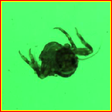

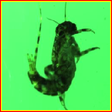

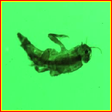

class:  2


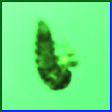

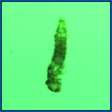

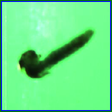

class:  3


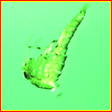

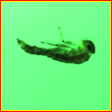

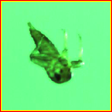

class:  4


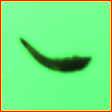

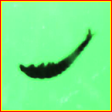

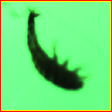

class:  5


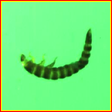

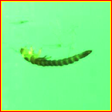

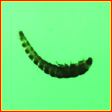

In [9]:
from PIL import ImageOps

for i in range(5):
    print('class: ' , i+1)
    for j in range(3):
        imageFile = 'detect/detect' + str(i+1) + '_' + str(j+1) + '.jpg'
        img = Image.open(imageFile)
        img.load()
        img = img.convert('RGB')
        if predictedClasses[j+i*3][0] == predictedClasses[j+i*3][1][0]:   
            fillA = 'blue'
            fillB = 'green'
        else:
            fillA = 'yellow'
            fillB = 'red'
        scale = int(224*0.5)
        img = ImageOps.expand(ImageOps.expand(img,border=2,fill=fillA),border=2,fill=fillB).resize((scale,scale),Image.ANTIALIAS)
        display(img)


In [10]:
acc.verboseLevel = 0
mode = 'complete'
imageFile = 'detect/detect5_3.jpg'
img = load_image(imageFile)
convertedX = np.expand_dims(img,axis=0)

nSamples = 30
samples = np.zeros(shape=(nSamples,))

for i in range(nSamples):
    t = acc.predict(convertedX)#,imageData=True)
    samples[i] = t[0]
    print("Predict no.", i)
    time.sleep(0.5)
    
    
print('mean: ',np.mean(samples), ', variance: ',np.var(samples))
import pickle
with open('vgg16times_'+mode+'_'+bitFileName+'.pkl','wb') as f:
    pickle.dump(samples,f)

Predict no. 0
Predict no. 1
Predict no. 2
Predict no. 3
Predict no. 4
Predict no. 5
Predict no. 6
Predict no. 7
Predict no. 8
Predict no. 9
Predict no. 10
Predict no. 11
Predict no. 12
Predict no. 13
Predict no. 14
Predict no. 15
Predict no. 16
Predict no. 17
Predict no. 18
Predict no. 19
Predict no. 20
Predict no. 21
Predict no. 22
Predict no. 23
Predict no. 24
Predict no. 25
Predict no. 26
Predict no. 27
Predict no. 28
Predict no. 29
mean:  2.00637757778 , variance:  0.020021916663


In [11]:
outputs = dict()
for layer in acc.layers:#layerList:
    #print(acc.outputs[layer])
    if 'input' not in layer:
        if 'conv' in layer or 'pool' in layer:
            nOutVars = acc.layers[layer].outputSize[0]* acc.layers[layer].outputSize[1]* acc.layers[layer].outputSize[2]
        else:
            nOutVars = acc.layers[layer].outputSize

        print(layer,nOutVars)
        out = acc.variableExtract(acc.outputs[layer][acc.layers[layer].finalOutIdx],int(nOutVars))
        outputs.update({layer:out})

block1_conv1 3211264.0


KeyboardInterrupt: 

In [ ]:
import pickle
with open('vgg16outputs'+bitFileName+'.pkl','wb') as f:
    pickle.dump(outputs,f)

In [ ]:
#pool 512
acc.verboseLevel = 0
mode = 'complete'
imageSize = 28
depth = 512
stride = 2
window = 2
dmaX = acc.xlnk.cma_array(shape=(int(imageSize*imageSize*depth/(acc.DMA_MULT))),dtype=np.uint64)
dmaY = acc.xlnk.cma_array(shape=(int((imageSize/stride*imageSize/stride*depth)/(acc.DMA_MULT))),dtype=np.uint64)

parameterBuffer = acc.allocParameterBufferPool()
acc.parameterCalcPool(parameterBuffer,depth, imageSize, stride, window, 0)

parameterBuffer = acc.convertNpToCma(parameterBuffer)

samples = np.zeros(shape = (30,))
for i in range(30):
    before = time.time()
    acc.doPool(parameterBuffer,dmaX,dmaY) #depth = 512, image_size = 28, stride = 2, window = 2, zeropad = 0
    after = time.time()
    samples[i] = after-before
    #print('pool 512 - time taken: ',after-before)

print('mean: ',np.mean(samples), ', variance: ',np.var(samples))
import pickle
with open('vgg16times_pool512_'+mode+'_'+bitFileName+'.pkl','wb') as f:
    pickle.dump(samples,f)

In [ ]:
#conv test
acc.verboseLevel = 0
mode = 'complete'
imageData = False
imageSize = 16
depth = 64
nW = 64
wSize = 3
stride = 1
padding = 1
xn = 1
dmaX = acc.xlnk.cma_array(shape = (int(xn*imageSize*imageSize*64/acc.DMA_MULT)), dtype=np.uint64)
dmaYConv = acc.allocDmaYArray(imageSize, wSize, nW, stride,padding)
dmaW = acc.allocateDmaWArray(wSize, depth, nW)
dmaWUse = acc.convertNpToCma(dmaW[0])

parameterBuffer = acc.allocParameterBufferConv()
acc.parameterCalcConv(parameterBuffer, wSize, dmaW[2], imageSize, stride, xn, nW, True, padding, imageData = imageData)

parameterBuffer = acc.convertNpToCma(parameterBuffer)

samples = np.zeros(shape = (30,))
for i in range(30):
    before = time.time()
    acc.doConv(parameterBuffer,dmaX,dmaWUse,dmaYConv)
    after = time.time()
    samples[i] = after-before
    #print('conv - time taken: ',after-before)

print('mean: ',np.mean(samples), ', variance: ',np.var(samples))
import pickle
with open('vgg16times_conv_'+mode+'_'+bitFileName+'.pkl','wb') as f:
    pickle.dump(samples,f)

In [ ]:
#image conv test
acc.verboseLevel = 0
mode = 'complete'
imageData = True
imageSize = 32
depth = 3
nW = 64
wSize = 3
stride = 1
padding = 1
dmaX = acc.xlnk.cma_array(shape = (imageSize,imageSize,3), dtype=np.uint8)
dmaY = acc.allocDmaYArray(imageSize, wSize, nW, stride,padding)
dmaW = acc.allocateDmaWArray(wSize, depth, nW)
dmaWUse = acc.convertNpToCma(dmaW[0])

parameterBuffer = acc.allocParameterBufferConv()
acc.parameterCalcConv(parameterBuffer, wSize, dmaW[2], imageSize, stride, xn, nW, True, padding, imageData = imageData)

parameterBuffer = acc.convertNpToCma(parameterBuffer)


samples = np.zeros(shape = (30,))
for i in range(30):
    before = time.time()
    acc.doConv(parameterBuffer, dmaX, dmaWUse, dmaY)
    after = time.time()
    samples[i] = after-before
    #print('image conv - time taken: ',after-before)

print('mean: ',np.mean(samples), ', variance: ',np.var(samples))
import pickle
with open('vgg16times_imageconv_'+mode+'_'+bitFileName+'.pkl','wb') as f:
    pickle.dump(samples,f)

In [ ]:
#pool 1
acc.verboseLevel = 0
mode = 'complete'
imageSize = 32
depth = 64
stride = 2
window = 2
dmaXpool1 = acc.xlnk.cma_array(shape=(int(imageSize*imageSize*depth/(acc.DMA_MULT))),dtype=np.uint64)
dmaYpool1 = acc.xlnk.cma_array(shape=(int((imageSize/stride*imageSize/stride*depth)/(acc.DMA_MULT))),dtype=np.uint64)

parameterBuffer = acc.allocParameterBufferPool()
acc.parameterCalcPool(parameterBuffer,depth, imageSize, stride, window, 0)

parameterBuffer = acc.convertNpToCma(parameterBuffer)

samples = np.zeros(shape = (30,))
for i in range(30):
    before = time.time()
    acc.doPool(parameterBuffer, dmaXpool1,dmaYpool1) 
    after = time.time()
    samples[i] = after-before
    #print('pool 1 - time taken: ',after-before)
print('mean: ',np.mean(samples), ', variance: ',np.var(samples))
import pickle
with open('vgg16times_pool1_'+mode+'_'+bitFileName+'.pkl','wb') as f:
    pickle.dump(samples,f)

In [ ]:
#fc test
acc.verboseLevel = 0
mode = 'complete'
imageSize = 16
depth = 64
nOut = 128
nIn = imageSize*imageSize*depth

dmaY = acc.allocateDmaYFCArray(nOut)
weight = acc.allocateDmaWFCArray(nIn,acc.PE_N)
dmaWbuffer = acc.convertNpToCma(weight[0])     
newUnits = weight[1]
nUnitsToLoad = acc.PE_N

DMAbytesAddPrSplit = acc.DATA_WIDTH/8*acc.PE_N

parameterBuffer = acc.allocParameterBufferFC()
acc.parameterCalcFC(parameterBuffer,nIn,nUnitsToLoad,newUnits,True)
parameterBuffer = acc.convertNpToCma(parameterBuffer)
        
samples = np.zeros(shape = (30,))
for j in range(30):
    before = time.time()
    for i in range(int(nOut/acc.PE_N)):

        outDMA = NNAccelerator.DMAidx(int(dmaY.nbytes-(DMAbytesAddPrSplit*i)),
            int(dmaY.physical_address + (DMAbytesAddPrSplit*i)),
            dmaY) 
        acc.doFC(parameterBuffer, dmaYpool1, dmaWbuffer, outDMA)
    after = time.time()
    samples[j] = after-before
    #print('fc - time taken: ',after-before)
print('mean: ',np.mean(samples), ', variance: ',np.var(samples))
import pickle
with open('vgg16times_fc_'+mode+'_'+bitFileName+'.pkl','wb') as f:
    pickle.dump(samples,f)      

In [ ]:
np.random.seed(0)
imageSize = 4
nImages = 1
depth = 64
wSize = 3
nW = 64
stitchBufDepth = 32
one = 2**8

dmaX = acc.xlnk.cma_array(shape=(int(imageSize*imageSize*depth/4)),dtype=np.uint64)
dmaY = acc.xlnk.cma_array(shape=(int(imageSize*imageSize*depth/4)+int(imageSize*imageSize*stitchBufDepth/4)),dtype=np.uint64)
dmaStitchBuf = acc.xlnk.cma_array(shape=(int(imageSize*imageSize*stitchBufDepth/4)),dtype=np.uint64)

for i in range(imageSize):
    for a in range(imageSize):
        for b in range(depth):
            dmaX[i*imageSize+b] = a*2**8
stride = 1
window = 3  
zeroPad = 1
weights = acc.convertNpToCma(acc.weights['block1_conv2'][0][0])
npWeights = np.copy(weights)
dmaIdx = NNAccelerator.DMAidx(npWeights.nbytes,npWeights.ctypes.data, npWeights)

acc.doConv(dmaX, weights, dmaY, window, depth, imageSize, stride, 1, nW, True,zeroPad,0,0,None)

acc.doConv(dmaX,weights , dmaY, window, depth, imageSize, stride, 1, nW, True,zeroPad,depth+stitchBufDepth,stitchBufDepth,dmaStitchBuf)